# Modelo #2 Red Convolucional Univariada

In [73]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
import pickle

from sklearn.metrics import r2_score
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [33]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Cargar Datos

In [34]:
df = pd.read_csv("HistoricalQuotes.csv")
df.head()

,date,close,volume,open,high,low
0,2019/03/14,19.95,73578.0,20.14,20.180,19.90
1,2019/03/13,20.10,103553.0,20.30,20.330,19.99
2,2019/03/12,20.37,101823.0,20.79,20.905,20.34
3,2019/03/11,20.89,74490.0,21.03,21.100,20.71
4,2019/03/08,20.99,137966.0,20.41,21.100,20.41


In [35]:
# Ordeno el dataframe por fecha
df = df.sort_values(by=['date'],ascending=True)
df = df.reset_index(drop=True)
df.head()

,date,close,volume,open,high,low
0,2009/03/16,1.51,66174.0,1.50,1.53,1.500
1,2009/03/17,1.51,35448.0,1.68,1.68,1.490
2,2009/03/18,1.49,26360.0,1.50,1.53,1.490
3,2009/03/19,1.41,189240.0,1.43,1.48,1.365
4,2009/03/20,1.45,76175.0,1.41,1.47,1.400


## CNN Univariada 

Tradicionalmente las redes convolucionales se han usado para la clasificación de imágenes, pero este tipo de Red puede ser usado para problemas de predicción de series.

La CNN no ve los datos como pasos de tiempo, en lugar son tratados como una secuencia sobre la cual la red convolucional lee los datos y los trata como si fueran una imagen de una dimensión

### Preprocesamiento

In [36]:
# En esta red cnn univariada solo vamos a utilizar la variable precio de cierre 
precio_cierre = df["close"].values.reshape(-1,1)

# creo mi objeto para normalizar mis datos de entrada
sc = MinMaxScaler(feature_range = (0, 1))

precio_cierre_normalizado = sc.fit_transform(precio_cierre)

### Partición de dataset

In [37]:
# Nro de días a predecir...
time_to_predict = 60

# todos los datos excepto los que voy a predecir 
data_train = precio_cierre_normalizado[0:-time_to_predict]

# datos que voy a predecir
data_test = precio_cierre_normalizado[-time_to_predict:len(precio_cierre_normalizado)]


### train/test

In [38]:
X_train = []
y_train = []

retardos = 20

# construcción de la estructura para la cnn de los datos
for i in range(retardos, len(data_train)):
    X_train.append(data_train[i-retardos:i, 0])
    y_train.append(data_train[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# añado una nueva dimensión a mis datos de entrenamiento, y cómo en este caso solo tengo
# uno solo predictor entonces pongo uno al final, [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Construcción de dataset para predecir 

In [39]:
# extraemos los datos necesarios del pasado para predecir enero, por ejm 
# si cogemos el 1 de enero necesitamos los n días de retardos anteriores a este y así sucesivamente...
inputs = precio_cierre_normalizado[(len(precio_cierre_normalizado) - len(data_test) - retardos):len(precio_cierre_normalizado)]

# vector columna para datos de prueba
inputs = inputs.reshape(-1,1)

X_test = []

# Como aquí solo necesitamos las entradas de nuestros test set solo son los días a predecir
for i in range(retardos, (retardos+(time_to_predict))):
    X_test.append(inputs[i-retardos:i, 0])

X_test = np.array(X_test)

# le añado una nueva dimensión a mi data test
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Construcción arquitectura CNN Univariada

<img src="https://cdn-images-1.medium.com/max/1600/1*uUYc126RU4mnTWwckEbctw@2x.png" width=500>

In [40]:
# solo precio de cierre
n_features = 1

### Tuning de Retardos

Se va buscar cuál es el número de parámetros más adecuado para la CNN univariada, los valores entre los que se van a buscar son: **[20,40,60,100]**

Suposición de Hiperparametros:

    * Capas ocultas             1
    * Neuronas por capa de Conv 128
    * lr                        0.001
    * epochs                    100
    * batch                     32

In [20]:
def tuning_retardos(nro_retardos):
    
    resultado_retardos = []
    
    for j in range(len(nro_retardos)):
        
        X_train = []
        y_train = []

        retardos = nro_retardos[j]

        # construcción de la estructura para la cnn de los datos
        for i in range(retardos, len(data_train)):
            X_train.append(data_train[i-retardos:i, 0])
            y_train.append(data_train[i, 0])

        X_train, y_train = np.array(X_train), np.array(y_train)

        # añado una nueva dimensión a mis datos de entrenamiento, y cómo en este caso solo tengo
        # uno solo predictor entonces pongo uno al final, [samples, timesteps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        
        
        # extraemos los datos necesarios del pasado para predecir enero, por ejm 
        # si cogemos el 1 de enero necesitamos los n días de retardos anteriores a este y así sucesivamente...
        inputs = precio_cierre_normalizado[(len(precio_cierre_normalizado) - len(data_test) - retardos):len(precio_cierre_normalizado)]

        # vector columna para datos de prueba
        inputs = inputs.reshape(-1,1)

        X_test = []

        # Como aquí solo necesitamos las entradas de nuestros test set solo son los días a predecir
        for i in range(retardos, (retardos+(time_to_predict))):
            X_test.append(inputs[i-retardos:i, 0])

        X_test = np.array(X_test)

        # le añado una nueva dimensión a mi data test
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        
        ################################################################################################################

        
        cnn_univariate = Sequential()                                                                # retardos        # nro de caracterisiticas
        cnn_univariate.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], n_features)))
        cnn_univariate.add(MaxPooling1D(pool_size=2))
        cnn_univariate.add(Flatten())    

        cnn_univariate.add(Dense(100, activation='relu'))
        cnn_univariate.add(Dense(1))

        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        
        cnn_univariate.compile(optimizer=adam, loss='mse')

        # entrenamiento
        history = cnn_univariate.fit(X_train, y_train, epochs =100,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)

        # predigo los datos de entrada de prueba
        predicted_stock_price = cnn_univariate.predict(X_test)

        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = precio_cierre[-(time_to_predict):]
        
        
        resultado_retardos.append([predicted_stock_price,
                                   real_stock_price,
                                   [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                    metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                    np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                    len(cnn_univariate.history.history['loss']),
                                    r2_score(real_stock_price,predicted_stock_price)                                    
                                   ])       
        
        
    return resultado_retardos

nro_retardos = [20,40,60,100]

resultado_tuning_retardos = tuning_retardos(nro_retardos)
         

Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 1s 344us/step - loss: 0.0107 - val_loss: 8.7772e-04
Epoch 2/100
1949/1949 [==============================] - 0s 96us/step - loss: 6.2550e-04 - val_loss: 0.0011
Epoch 3/100
1949/1949 [==============================] - 0s 94us/step - loss: 5.7300e-04 - val_loss: 8.6146e-04
Epoch 4/100
1949/1949 [==============================] - 0s 96us/step - loss: 5.8067e-04 - val_loss: 9.9524e-04
Epoch 5/100
1949/1949 [==============================] - 0s 97us/step - loss: 4.8332e-04 - val_loss: 6.6755e-04
Epoch 6/100
1949/1949 [==============================] - 0s 101us/step - loss: 4.8675e-04 - val_loss: 0.0012
Epoch 7/100
1949/1949 [==============================] - 0s 100us/step - loss: 4.9296e-04 - val_loss: 6.1735e-04
Epoch 8/100
1949/1949 [==============================] - 0s 90us/step - loss: 4.6162e-04 - val_loss: 5.7232e-04
Epoch 9/100
1949/1949 [==============================] - 0s 91us/s

1933/1933 [==============================] - 0s 188us/step - loss: 3.1488e-04 - val_loss: 5.3407e-04
Epoch 41/100
1933/1933 [==============================] - 0s 189us/step - loss: 3.1292e-04 - val_loss: 5.3503e-04
Epoch 42/100
1933/1933 [==============================] - 0s 181us/step - loss: 3.1210e-04 - val_loss: 5.3374e-04
Epoch 43/100
1933/1933 [==============================] - 0s 178us/step - loss: 3.1149e-04 - val_loss: 5.3485e-04
Epoch 44/100
1933/1933 [==============================] - 0s 184us/step - loss: 3.1143e-04 - val_loss: 5.3499e-04

Epoch 00044: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 45/100
1933/1933 [==============================] - 0s 183us/step - loss: 3.1158e-04 - val_loss: 5.4206e-04
Epoch 46/100
1933/1933 [==============================] - 0s 181us/step - loss: 3.1284e-04 - val_loss: 5.3488e-04
Epoch 47/100
1933/1933 [==============================] - 0s 184us/step - loss: 3.1081e-04 - val_loss: 5.3731e-04
Epoch 48/100
1933/19

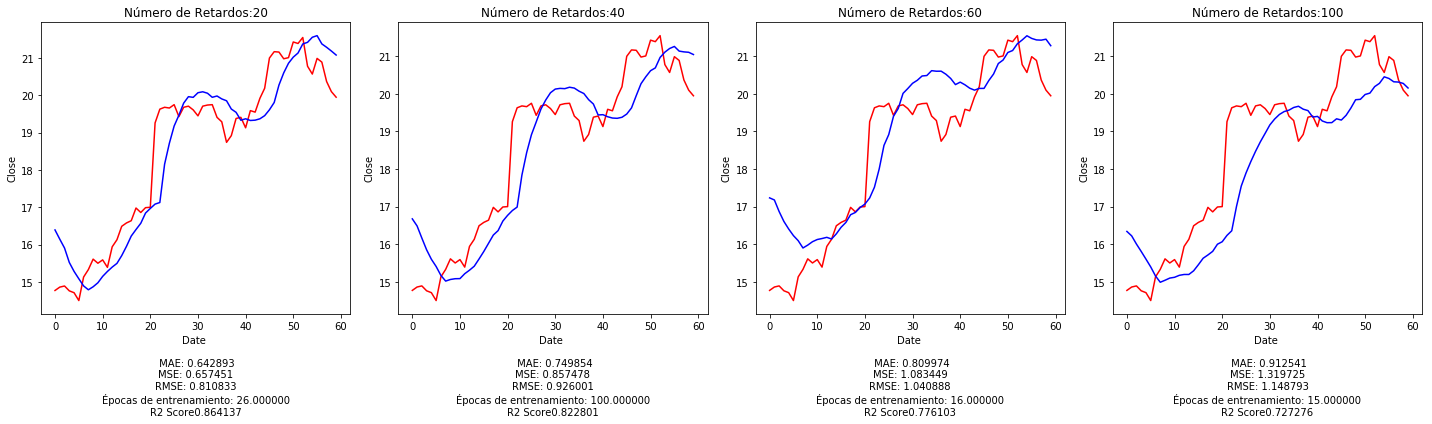

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,6))

count = 0
for ax in axes:    
        
    titulo = str("Número de retardos:"+str(nro_retardos[count])) 
        
    ax.plot(resultado_tuning_retardos[count][1],color = 'red',label = 'Real S&P Stock Price')
    ax.plot(resultado_tuning_retardos[count][0],color = 'blue',label = 'Predicted S&P Stock Price')
    
    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_tuning_retardos[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(resultado_tuning_retardos[count][4])) 
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Retardos:'+str(nro_retardos[count])))

    fig    
    plt.tight_layout()
    
    count+=1



**Resultado tuning de retardos:**

*Retardos: 20*

*Obtuvo Menor error en las 3 métricas de error (MAE,MSE,RMSE) y  mayor R2 Score (0.864)*

## Tuning capas

Luego de conocer cual es el número de retardos más adecuado (200), se procede a buscar cuál es el número de capas ocultas con mejor rendimiento

Se van a suponer los siguientes hiperparámetros

    * Por cada nueva capa convolucional se reduce los filtros a la mitad 
    * filtros en la capa conv inicial  128 
    * lr                               0.001
    * batch                            32
    * epochs                           100

In [43]:
def grid_layers(layers):
    
    resultado_capas = []
    
    for i in range(len(layers)):   

        cnn_univariate = Sequential()                                                        # retardos        # nro de caracterisiticas
        cnn_univariate.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], n_features)))
        cnn_univariate.add(MaxPooling1D(pool_size=2))
        #cnn_univariate.add(Flatten())

        
        for j in range(layers[i]-1):
            
            cnn_univariate.add(Conv1D(filters=int(128/layers[i]), kernel_size=2, activation='relu'))
            

        cnn_univariate.add(MaxPooling1D(pool_size=2))
        cnn_univariate.add(Flatten())

        cnn_univariate.add(Dense(100, activation='relu'))
        cnn_univariate.add(Dense(1))

        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        # mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

        cnn_univariate.compile(optimizer=adam, loss='mse')

        # entrenamiento
        history = cnn_univariate.fit(X_train, y_train, epochs =100,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)

        
        # predigo los datos de entrada de prueba
        predicted_stock_price = cnn_univariate.predict(X_test)

        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = precio_cierre[-(time_to_predict):]
        
        
        resultado_capas.append([predicted_stock_price,
                               real_stock_price,
                               [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                len(cnn_univariate.history.history['loss']),
                                r2_score(real_stock_price,predicted_stock_price)   
                               ])
    
    return resultado_capas


layers = [0,2,4,8]
resultado_arquitectura_capas = grid_layers(layers)


Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 1s 460us/step - loss: 0.0136 - val_loss: 0.0012
Epoch 2/100
1949/1949 [==============================] - 0s 94us/step - loss: 8.5847e-04 - val_loss: 0.0012
Epoch 3/100
1949/1949 [==============================] - 0s 106us/step - loss: 8.2805e-04 - val_loss: 0.0013
Epoch 4/100
1949/1949 [==============================] - 0s 122us/step - loss: 8.2773e-04 - val_loss: 0.0012
Epoch 5/100
1949/1949 [==============================] - 0s 96us/step - loss: 7.8698e-04 - val_loss: 0.0012
Epoch 6/100
1949/1949 [==============================] - 0s 108us/step - loss: 7.6263e-04 - val_loss: 0.0012
Epoch 7/100
1949/1949 [==============================] - 0s 93us/step - loss: 7.4031e-04 - val_loss: 0.0012
Epoch 8/100
1949/1949 [==============================] - 0s 94us/step - loss: 7.2997e-04 - val_loss: 0.0011
Epoch 9/100
1949/1949 [==============================] - 0s 95us/step - loss: 6.9710e-04 

1949/1949 [==============================] - 0s 125us/step - loss: 4.6925e-04 - val_loss: 0.0017
Epoch 18/100
1949/1949 [==============================] - 0s 128us/step - loss: 4.7473e-04 - val_loss: 6.7794e-04
Epoch 19/100
1949/1949 [==============================] - 0s 125us/step - loss: 4.3081e-04 - val_loss: 6.9522e-04
Epoch 20/100
1949/1949 [==============================] - 0s 128us/step - loss: 5.4212e-04 - val_loss: 0.0013
Epoch 21/100
1949/1949 [==============================] - 0s 125us/step - loss: 4.8082e-04 - val_loss: 8.9203e-04
Epoch 22/100
1949/1949 [==============================] - 0s 127us/step - loss: 4.1528e-04 - val_loss: 6.0361e-04
Epoch 23/100
1949/1949 [==============================] - 0s 125us/step - loss: 4.1477e-04 - val_loss: 5.9617e-04
Epoch 24/100
1949/1949 [==============================] - 0s 128us/step - loss: 3.8567e-04 - val_loss: 6.1767e-04

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 25/100
1949/1949 [====

1949/1949 [==============================] - 0s 203us/step - loss: 3.8347e-04 - val_loss: 6.2954e-04
Epoch 52/100
1949/1949 [==============================] - 0s 186us/step - loss: 3.8250e-04 - val_loss: 6.3327e-04
Epoch 53/100
1949/1949 [==============================] - 0s 191us/step - loss: 3.8260e-04 - val_loss: 6.3246e-04
Epoch 54/100
1949/1949 [==============================] - 0s 190us/step - loss: 3.8211e-04 - val_loss: 6.3654e-04
Epoch 55/100
1949/1949 [==============================] - 0s 184us/step - loss: 3.8263e-04 - val_loss: 6.2360e-04

Epoch 00055: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 56/100
1949/1949 [==============================] - 0s 187us/step - loss: 3.8194e-04 - val_loss: 6.3336e-04
Epoch 57/100
1949/1949 [==============================] - 0s 184us/step - loss: 3.8175e-04 - val_loss: 6.2868e-04
Epoch 58/100
1949/1949 [==============================] - 0s 193us/step - loss: 3.8156e-04 - val_loss: 6.2889e-04
Epoch 59/100
1949/1

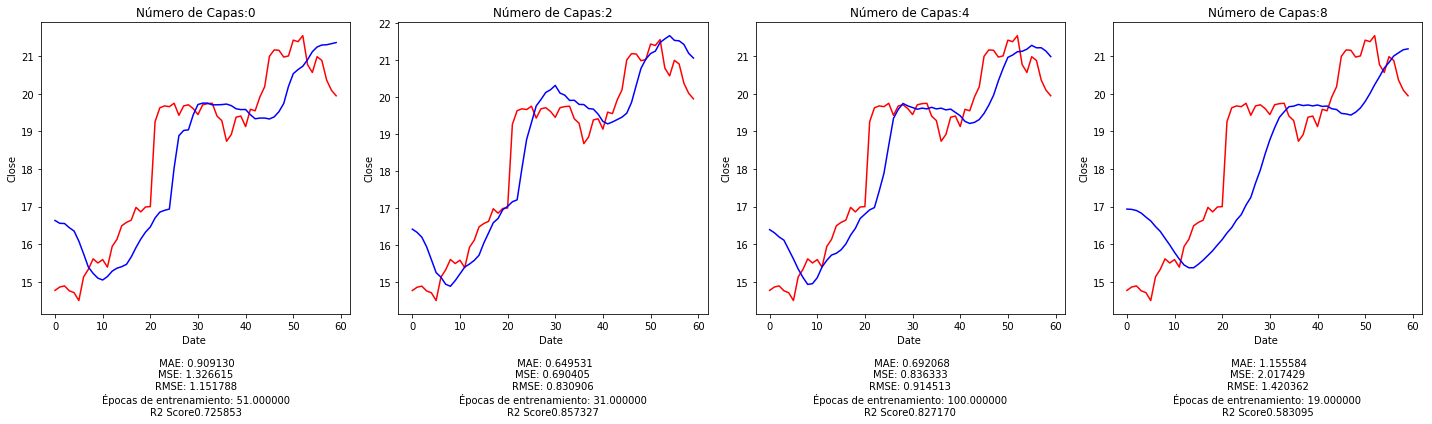

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,6))

count = 0
for ax in axes:    
        
    titulo = str("Número de capas:"+str(layers[count])) 
    
    ax.plot(resultado_arquitectura_capas[count][1],color = 'red',label = 'Real S&P Stock Price')
    ax.plot(resultado_arquitectura_capas[count][0],color = 'blue',label = 'Predicted S&P Stock Price')
    
    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_arquitectura_capas[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(resultado_arquitectura_capas[count][4])) 
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Capas:'+str(layers[count])))

    fig    
    plt.tight_layout()
    
    count+=1


**Resultado tuning capas ocultas:**

Se seleccionan **2 capas ocultas**, menor error en las 3 métricas de error y mayor R2

---


### Tunning neuronas

Se va a seleccionar el número de filtros en cada capa Conv1D en nuestra red

Se supone los siguientes hiperparámetros :
    
    * Layers     2
    * retardos   20
    * lr         0.001
    * batch size 32
    * epochs     100

In [54]:
def grid_neurons(neuronas):
    
    resultado_neuronas = []
    
    for i in range(len(neuronas)):
        
        cnn_univariate = Sequential()                                                        # retardos        # nro de caracterisiticas
        cnn_univariate.add(Conv1D(filters=neuronas[i], kernel_size=2, activation='relu', input_shape=(X_train.shape[1], n_features)))
        cnn_univariate.add(MaxPooling1D(pool_size=2))
        
        cnn_univariate.add(Conv1D(filters=int(neuronas[i]/2), kernel_size=2, activation='relu'))
        cnn_univariate.add(MaxPooling1D(pool_size=2))
        
        cnn_univariate.add(Flatten())    

        cnn_univariate.add(Dense(100, activation='relu'))
        cnn_univariate.add(Dense(1))

        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        # mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

        cnn_univariate.compile(optimizer=adam, loss='mse')

        # entrenamiento
        history = cnn_univariate.fit(X_train, y_train, epochs =100,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)

        
        # predigo los datos de entrada de prueba
        predicted_stock_price = cnn_univariate.predict(X_test)

        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = precio_cierre[-(time_to_predict):]
        
        
        resultado_neuronas.append([predicted_stock_price,
                               real_stock_price,
                               [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                len(cnn_univariate.history.history['loss']),
                                r2_score(real_stock_price,predicted_stock_price) 
                               ])
        
    return resultado_neuronas

neuronas = [32,64,128,256]
resultado_arquitectura_neuronas = grid_neurons(neuronas)
        

Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 2s 846us/step - loss: 0.0235 - val_loss: 0.0016
Epoch 2/100
1949/1949 [==============================] - 0s 95us/step - loss: 8.7248e-04 - val_loss: 0.0013
Epoch 3/100
1949/1949 [==============================] - 0s 108us/step - loss: 8.1773e-04 - val_loss: 0.0014
Epoch 4/100
1949/1949 [==============================] - 0s 92us/step - loss: 8.0295e-04 - val_loss: 0.0013
Epoch 5/100
1949/1949 [==============================] - 0s 93us/step - loss: 7.7630e-04 - val_loss: 0.0013
Epoch 6/100
1949/1949 [==============================] - 0s 107us/step - loss: 7.6276e-04 - val_loss: 0.0013
Epoch 7/100
1949/1949 [==============================] - 0s 95us/step - loss: 7.0502e-04 - val_loss: 0.0011
Epoch 8/100
1949/1949 [==============================] - 0s 90us/step - loss: 7.1967e-04 - val_loss: 9.8942e-04
Epoch 9/100
1949/1949 [==============================] - 0s 93us/step - loss: 6.5823e-

1949/1949 [==============================] - 0s 105us/step - loss: 3.4374e-04 - val_loss: 5.9019e-04
Epoch 31/100
1949/1949 [==============================] - 0s 105us/step - loss: 3.4526e-04 - val_loss: 6.0426e-04
Epoch 32/100
1949/1949 [==============================] - 0s 104us/step - loss: 3.5397e-04 - val_loss: 6.2674e-04

Epoch 00032: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 33/100
1949/1949 [==============================] - 0s 107us/step - loss: 3.4004e-04 - val_loss: 5.7820e-04
Epoch 34/100
1949/1949 [==============================] - 0s 106us/step - loss: 3.3667e-04 - val_loss: 5.8990e-04
Epoch 35/100
1949/1949 [==============================] - 0s 107us/step - loss: 3.3401e-04 - val_loss: 5.6924e-04
Epoch 36/100
1949/1949 [==============================] - 0s 105us/step - loss: 3.3877e-04 - val_loss: 5.7697e-04
Epoch 37/100
1949/1949 [==============================] - 0s 103us/step - loss: 3.3526e-04 - val_loss: 5.6634e-04

Epoch 00037: Reduce

1949/1949 [==============================] - 0s 107us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04
Epoch 94/100
1949/1949 [==============================] - 0s 122us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04
Epoch 95/100
1949/1949 [==============================] - 0s 122us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04
Epoch 96/100
1949/1949 [==============================] - 0s 109us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04
Epoch 97/100
1949/1949 [==============================] - 0s 109us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04

Epoch 00097: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
Epoch 98/100
1949/1949 [==============================] - 0s 123us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04
Epoch 99/100
1949/1949 [==============================] - 0s 106us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04
Epoch 100/100
1949/1949 [==============================] - 0s 123us/step - loss: 3.3143e-04 - val_loss: 5.6343e-04
Train on 1949 sampl

Epoch 11/100
1949/1949 [==============================] - 0s 224us/step - loss: 4.7363e-04 - val_loss: 7.3193e-04
Epoch 12/100
1949/1949 [==============================] - 0s 229us/step - loss: 5.0684e-04 - val_loss: 6.8516e-04
Epoch 13/100
1949/1949 [==============================] - 0s 233us/step - loss: 4.7298e-04 - val_loss: 8.6817e-04
Epoch 14/100
1949/1949 [==============================] - 0s 234us/step - loss: 4.4272e-04 - val_loss: 7.4680e-04
Epoch 15/100
1949/1949 [==============================] - 0s 247us/step - loss: 4.5263e-04 - val_loss: 8.5660e-04
Epoch 16/100
1949/1949 [==============================] - 0s 248us/step - loss: 4.0418e-04 - val_loss: 7.9494e-04

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 17/100
1949/1949 [==============================] - 0s 237us/step - loss: 4.0045e-04 - val_loss: 6.7662e-04
Epoch 18/100
1949/1949 [==============================] - 1s 263us/step - loss: 4.1891e-04 - val_loss: 6.3103e-04
Epoch 1

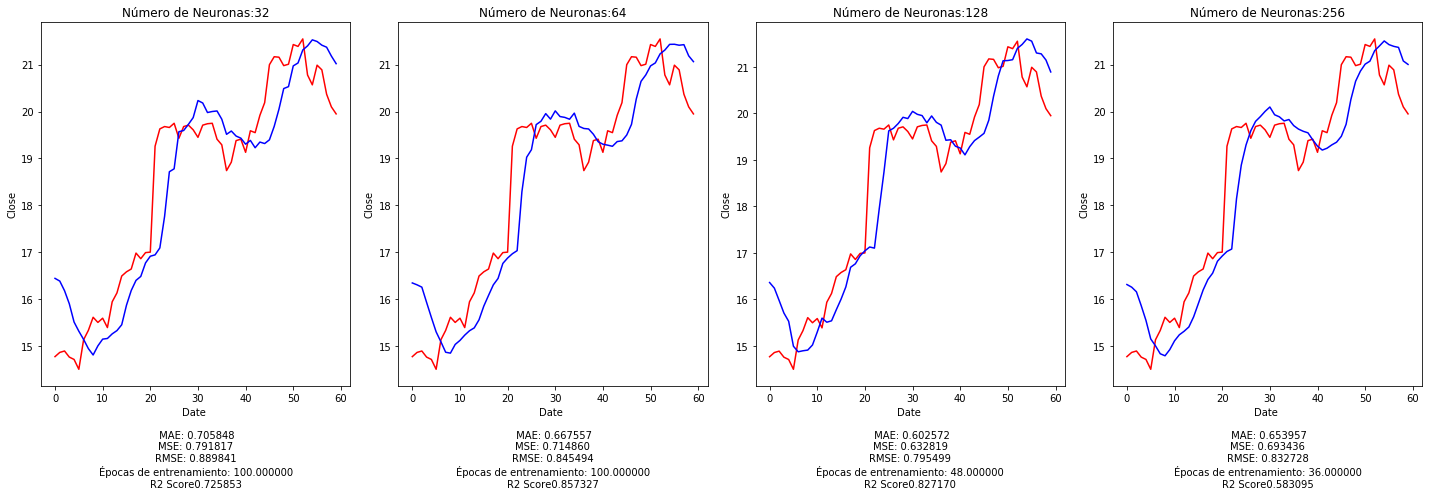

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,7))

count = 0
for ax in axes:  

    titulo = str("Número de Neuronas:"+str(neuronas[count])) 

    ax.plot(resultado_arquitectura_neuronas[count][1],color = 'red',label = 'Real S&P Stock Price')
    ax.plot(resultado_arquitectura_neuronas[count][0],color = 'blue',label = 'Predicted S&P Stock Price')

    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(resultado_arquitectura_capas[count][4])) 
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Neuronas:'+str(neuronas[count])))

    fig    
    plt.tight_layout()

    count+=1


**Resultado tuning neruonas**

**Se selecciona 128 porque a pesar de que tiene un R2 inferior que con 64 tiene menos errores en las otras métricas**

## Modelo final Convolucional univariada

2 capas (128 y 64  filtros capas Convolucionales)

lr = 0.001

retardo 20


In [56]:
cnn_univariate = Sequential()                                                                 # retardos        # nro de caracterisiticas
cnn_univariate.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], n_features)))
cnn_univariate.add(MaxPooling1D(pool_size=2))

cnn_univariate.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_univariate.add(MaxPooling1D(pool_size=2))

cnn_univariate.add(Flatten())    

cnn_univariate.add(Dense(100, activation='relu'))
cnn_univariate.add(Dense(1))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)


es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

cnn_univariate.compile(optimizer=adam, loss='mse')

# entrenamiento
history = cnn_univariate.fit(X_train, y_train, epochs =100,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)


# predigo los datos de entrada de prueba
predicted_stock_price = cnn_univariate.predict(X_test)

# aplico la transformación inversa para dejar los datos en la escala inicial
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# precios reales
real_stock_price = precio_cierre[-(time_to_predict):]       

Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 2s 1ms/step - loss: 0.0180 - val_loss: 0.0012
Epoch 2/100
1949/1949 [==============================] - 0s 161us/step - loss: 8.4102e-04 - val_loss: 0.0015
Epoch 3/100
1949/1949 [==============================] - 0s 155us/step - loss: 8.0589e-04 - val_loss: 0.0012
Epoch 4/100
1949/1949 [==============================] - 0s 158us/step - loss: 7.4889e-04 - val_loss: 0.0011
Epoch 5/100
1949/1949 [==============================] - 0s 155us/step - loss: 7.0081e-04 - val_loss: 0.0010
Epoch 6/100
1949/1949 [==============================] - 0s 148us/step - loss: 6.8489e-04 - val_loss: 9.5583e-04
Epoch 7/100
1949/1949 [==============================] - 0s 156us/step - loss: 6.4745e-04 - val_loss: 9.1284e-04
Epoch 8/100
1949/1949 [==============================] - 0s 155us/step - loss: 6.1682e-04 - val_loss: 9.1042e-04
Epoch 9/100
1949/1949 [==============================] - 0s 154us/step - lo

Epoch 66/100
1949/1949 [==============================] - 0s 174us/step - loss: 3.6485e-04 - val_loss: 6.0655e-04

Epoch 00066: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 67/100
1949/1949 [==============================] - 0s 151us/step - loss: 3.6478e-04 - val_loss: 6.0662e-04
Epoch 68/100
1949/1949 [==============================] - 0s 149us/step - loss: 3.6481e-04 - val_loss: 6.0689e-04
Epoch 69/100
1949/1949 [==============================] - 0s 146us/step - loss: 3.6484e-04 - val_loss: 6.0698e-04
Epoch 70/100
1949/1949 [==============================] - 0s 146us/step - loss: 3.6487e-04 - val_loss: 6.0673e-04
Epoch 71/100
1949/1949 [==============================] - 0s 153us/step - loss: 3.6487e-04 - val_loss: 6.0676e-04

Epoch 00071: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 72/100
1949/1949 [==============================] - 0s 150us/step - loss: 3.6477e-04 - val_loss: 6.0679e-04
Epoch 73/100
1949/1949 [===============

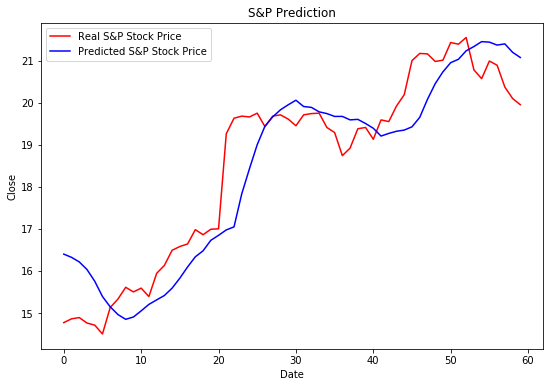

In [57]:
figure(figsize=(9,6))
plt.plot(real_stock_price, color = 'red', label = 'Real S&P Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted S&P Stock Price')
plt.title('S&P Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [60]:
print("R2 score:",r2_score(real_stock_price,predicted_stock_price))

R2 score: 0.8366247277505662


In [71]:
#guardo el modelo en disco
cnn_univariate.save("cnn_univariate.h5") 

In [74]:
## escribo X_test para modelo 2 para luego leerla
with open('X_test_2.data', 'wb') as filehandle:  
    pickle.dump(X_test, filehandle)